# Metropolis-Hastings Sampler for Parameter Estimation

## Code

In [1]:
%pylab inline
from numpy import *
from scipy.integrate import odeint as ode

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load data.
data = np.loadtxt("dimer_observations.dat")
timeObs = data[:,0]
pObs = data[:,1]

#Linspace for the ODE solver ( Tmin=0.0, Tmax=30.0).
time = linspace(0, 30, 3000)

C:\Users\josey\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


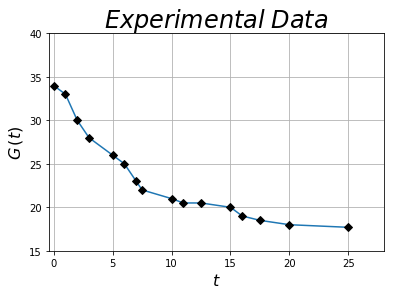

In [3]:
#The minimun of the experimental data.
minimum = timeObs[0]

#Shift the data as to begin in time t=0.
for i in range(len(timeObs)):
    aux = timeObs[i]
    timeObs[i] = aux - minimum

plot(timeObs, pObs)
plot(timeObs,pObs,'kD')
xlabel('$t$', size='16')
ylabel('$G\,(t)$', size='16')
title('$Experimental \; Data$', size='24')
grid('on')
xlim([-0.4,28])
ylim([15,40]) 
savefig('Glucosaexperimentaldata.png')

In [5]:
#The ODE solver step.
steps =  max(time)/ len(time)

positions=[]
for t in timeObs:
    #get the position in the solution array for the predicted valued by the model (Solution to the ODE) at the same time as the measurements where taken.
    if(t==0):
        positions.append(0)
    else:
        positions.append(int((t/steps)))#Based on the ODE solver.
        
positions

[0,
 100,
 200,
 300,
 500,
 600,
 700,
 750,
 1000,
 1100,
 1250,
 1500,
 1600,
 1750,
 2000,
 2500]

In [11]:
#Calculate the likelihood.
def likelihood(yModel):
    #Array for comparison with data array.
    yModelMod = []
    
    #Search the values of the model at the same time as measurements where made.
    for n in positions:
        yModelMod = append(yModelMod, yModel[n])
    
    #Compute the chi^2.
    chiSquared = sum((pObs-yModelMod)**2)
    
    #Clear the auxiliar array.
    yModelMod.resize(0)
    
    return (chiSquared)

#Random parameter generation.
def generateParams():
    #Array with random parameters.
    p= array(random.uniform(0,10, size=5))
    return p    

#RHS of the equation
def f(P,t,alpha,beta,S_0,K_m1,K_m2):    
    f=(alpha*(S_0-P)/(K_m1+S_0-P))-((beta*P)/(K_m2+P))
    return f

def solve(params):

    # Initial condition
    y0 = pObs[0]
    
    #parameters
    alpha=params[0]
    beta=params[1]
    S_0=params[2]
    K_m1=params[3]
    K_m2=params[4]

    # Solve the equation. (Python odeint)
    y = ode(f, y0, time, args=(alpha,beta,S_0,K_m1,K_m2,))
    
    return y

In [6]:
params = generateParams()
print params

[ 8.5895603   0.22459082  0.25693112  4.49789472  7.98969147]


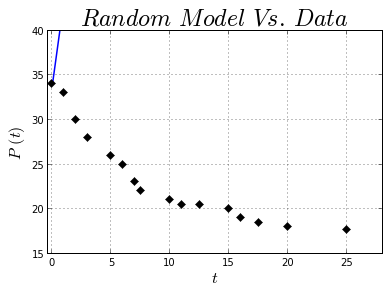

In [114]:
guess = solve(params) 
plot(time,guess, linewidth='1.5')
plot(timeObs,pObs, 'kD')
xlabel('$t$', size='16')
ylabel('$P\,(t)$', size='16')
title('$Random \,Model \, Vs. \, Data$', size='24')
grid('on')
xlim([-0.4,28])
ylim([15,40])
savefig('randomModel.png')

In [8]:
chiguess = likelihood(guess)
print 'Guess Chi² = '+str(chiguess)

Guess Chi² = 226886.116732


In [9]:
#MCMC steps.
nIterations = 20000

#Arrays to store the parameters inside the MC.
alpha = empty((0))
beta = empty((0))
S_0 = empty((0))
K_m1 = empty((0))
K_m2 = empty((0))
chi = empty((0))

#Append the random parameters guessed earlier.
alpha = append(alpha,params[0])
beta = append(beta,params[1])
S_0 = append(S_0,params[2])
K_m1 = append(K_m1,params[3])
K_m2 = append(K_m2,params[4])
chi = append(chi, likelihood(guess))

In [10]:
#Accetance counter.
accepted  = 0.0

#The actual MCMC.
for k in range (nIterations):

    #Generate random positive parameters based on a Gaussian distribution.
    alphaProposed = abs(random.normal(alpha[k],0.1))
    betaProposed = abs(random.normal(beta[k],0.1))
    S_0Proposed = abs(random.normal(beta[k],0.1))
    K_m1Proposed = abs(random.normal(beta[k],0.1))
    K_m2Proposed = abs(random.normal(beta[k],0.1))
    
    oldParams = [alpha[k], beta[k], S_0[k], K_m1[k], K_m2[k]]
    newParams = [alphaProposed, betaProposed, S_0Proposed, K_m1Proposed, K_m2Proposed]
    
    yOld = solve(oldParams)
    yNew = solve(newParams)
    
    A = likelihood(yNew) - likelihood(yOld)
    
    if(A<=0):
        
        alpha  = append(alpha,alphaProposed)
        beta = append(beta,betaProposed)
        S_0 = append(S_0,S_0Proposed)
        K_m1 = append(K_m1,K_m1Proposed)
        K_m2 = append(K_m2,K_m2Proposed)
        chi = append(chi, likelihood(yNew))
        
        accepted = accepted + 1
    else:
        B = random.random()
        if(B<=exp(-A)):
            alpha  = append(alpha,alphaProposed)
            beta = append(beta,betaProposed)
            S_0 = append(S_0,S_0Proposed)
            K_m1 = append(K_m1,K_m1Proposed)
            K_m2 = append(K_m2,K_m2Proposed)
            chi = append(chi, likelihood(yNew))
        
            accepted = accepted + 1
            
        else: 
            
            alpha  = append(alpha,alpha[k])
            beta = append(beta,beta[k])
            S_0 = append(S_0,S_0[k])
            K_m1 = append(K_m1,K_m1[k])
            K_m2 = append(K_m2,K_m2[k])
            chi = append(chi, likelihood(yOld))
        
print "Acceptance rate = "+str(accepted/nIterations)

Acceptance rate = 0.2112


In [11]:
cleanA = []
cleanB = []
cleanS = []
cleanK1 = []
cleanK2 = []
cleanChi = [] 
#Discard the fist half of the MCMC.
for n in range((nIterations/2),nIterations):
        cleanA.append(alpha[n])
        cleanB.append(beta[n])
        cleanS.append(S_0[n])
        cleanK1.append(K_m1[n])
        cleanK2.append(K_m2[n])
        cleanChi.append(chi[n])

#Get Averages.        
AAvg = average(cleanA)
BAvg = average(cleanB)
SAvg = average(cleanS)
K1Avg = average(cleanK1)
K2Avg = average(cleanK2)
CAVG = average(cleanChi)

#Get Standard Deviation.
ASd = std(cleanA)
BSd = std(cleanB)
SSd = std(cleanS)
K1Sd = std(cleanK1)
K2Sd = std(cleanK2)
CSd = std(cleanChi)

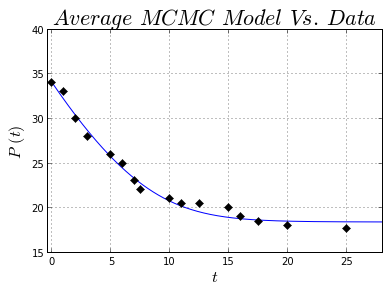

In [115]:
paramsAvg = [AAvg, BAvg, SAvg, K1Avg, K2Avg]
solutionAvg = solve(paramsAvg)
plot(time, solutionAvg)
plot(timeObs,pObs, 'kD')
xlabel('$t$', size='16')
ylabel('$P\,(t)$', size='16')
title('$Average \, MCMC \,Model \, Vs. \, Data$', size='22')
grid('on')
xlim([-0.4,28])
ylim([15,40])
savefig('averageModel.png')

In [13]:
print "Alpha average = "+str(AAvg)+" +- "+ str(ASd) +"\n"
print "Beta average = "+str(BAvg)+" +- "+ str(BSd) +"\n"
print "S_0 average = "+str(SAvg)+" +- "+ str(SSd) +"\n"
print "K_m1 average = "+str(K1Avg)+" +- "+ str(K1Sd) +"\n"
print "K_m2 average = "+str(K2Avg)+" +- "+ str(K2Sd) +"\n"
print "Chi² average = "+str(CAVG)

Alpha average = 2.39063788346 +- 0.109239237521

Beta average = 5.78664331127 +- 0.453661877442

S_0 average = 5.7879946127 +- 0.40581521834

K_m1 average = 5.78878643678 +- 0.36216175709

K_m2 average = 5.79443645448 +- 0.425506042705

Chi² average = 8.0477865441


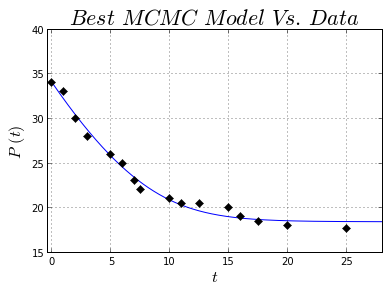

In [116]:
chiMin = min(chi)
opt = argmin(chi)
paramsOpt = [alpha[opt], beta[opt], S_0[opt], K_m1[opt], K_m2[opt]]
solutionOpt = solve(paramsOpt)
plot(time, solutionOpt)
plot(timeObs,pObs, 'kD')
xlabel('$t$', size='16')
ylabel('$P\,(t)$', size='16')
title('$Best \, MCMC \,Model \, Vs. \, Data$', size='22')
grid('on')
xlim([-0.4,28])
ylim([15,40])
savefig('bestModel.png')

In [15]:
print "Best Alpha = "+str(alpha[opt])+"\n"
print "Best Beta = "+str(beta[opt])+"\n"
print "Best S_0 = "+str(S_0[opt])+"\n"
print "Best K_m1 = "+str(K_m1[opt])+"\n"
print "Best K_m2 = "+str(K_m2[opt])+"\n"
print "Best Chi² = "+str(chiMin)

Best Alpha = 2.51607782182

Best Beta = 5.91720534011

Best S_0 = 5.63619971947

Best K_m1 = 5.68734231605

Best K_m2 = 5.73130546261

Best Chi² = 5.32548048121


## $\chi^2$ Graph

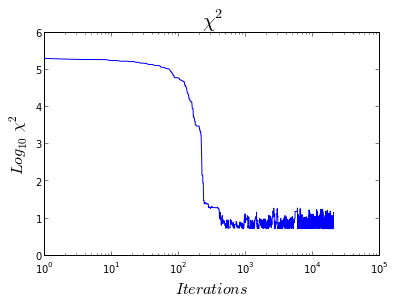

In [16]:
plot(log10(chi))
xscale('log')
xlabel('$Iterations$', size='16')
ylabel('$Log_{10}\,\chi^2$', size='16')
title('$\chi^2$', size='20')
savefig('chiSq.png')

## $\alpha$ Walks Scatter Plots

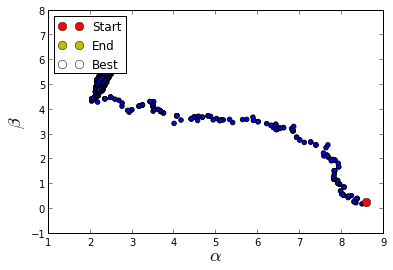

In [17]:
scatter(alpha, beta)
plot(alpha[0],beta[0],"ro", ms=8.0, label='Start')
plot(alpha[-1],beta[-1],"yo", ms=8.0, label='End')
plot(alpha[opt],beta[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\alpha$', size='18')
ylabel(r'$\beta$', size='18')
legend(loc=2)
savefig('alphaBetaWalk.png')

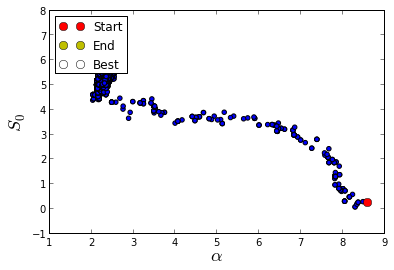

In [18]:
scatter(alpha, S_0)
plot(alpha[0],S_0[0],"ro", ms=8.0, label='Start')
plot(alpha[-1],S_0[-1],"yo", ms=8.0, label='End')
plot(alpha[opt],S_0[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\alpha$', size='18')
ylabel('$S_0$', size='18')
legend(loc=2)
savefig('alphaS0Walk.png')

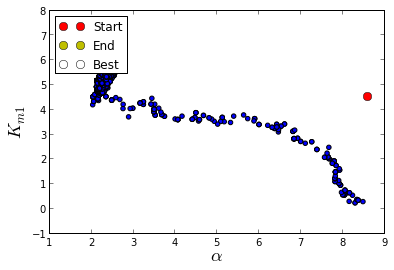

In [117]:
scatter(alpha, K_m1)
plot(alpha[0],K_m1[0],"ro", ms=8.0, label='Start')
plot(alpha[-1],K_m1[-1],"yo", ms=8.0, label='End')
plot(alpha[opt],K_m1[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\alpha$', size='18')
ylabel('$K_{m1}$', size='18')
legend(loc=2)
savefig('alphaK1Walk.png')

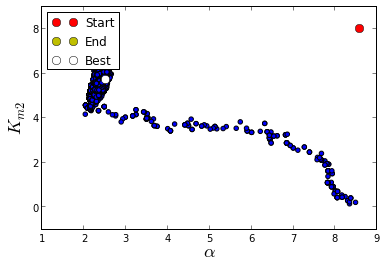

In [20]:
scatter(alpha, K_m2)
plot(alpha[0],K_m2[0],"ro", ms=8.0, label='Start')
plot(alpha[-1],K_m2[-1],"yo", ms=8.0, label='End')
plot(alpha[opt],K_m2[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\alpha$', size='18')
ylabel('$K_{m2}$', size='18')
legend(loc=2)
savefig('alphaK2Walk.png')

## $\beta$ Walks Scatter Plots

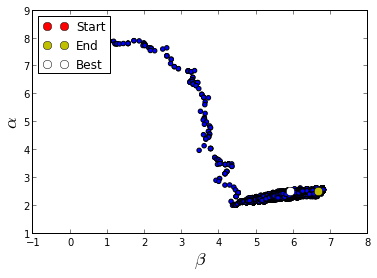

In [21]:
scatter(beta, alpha)
plot(beta[0],alpha[0],"ro", ms=8.0, label='Start')
plot(beta[-1],alpha[-1],"yo", ms=8.0, label='End')
plot(beta[opt],alpha[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\beta$', size='18')
ylabel(r'$\alpha$', size='18')
legend(loc=2)
savefig('betaAlphaWalk.png')

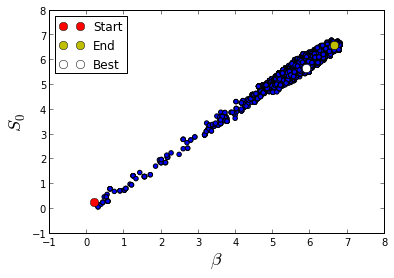

In [22]:
scatter(beta, S_0)
plot(beta[0],S_0[0],"ro", ms=8.0, label='Start')
plot(beta[-1],S_0[-1],"yo", ms=8.0, label='End')
plot(beta[opt],S_0[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\beta$', size='18')
ylabel(r'$S_0$', size='18')
legend(loc=2)
savefig('betaS0Walk.png')

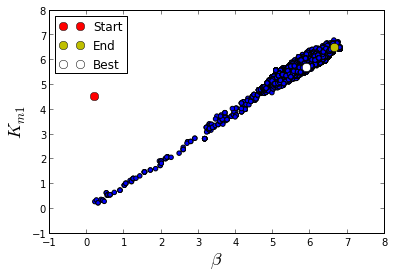

In [23]:
scatter(beta, K_m1)
plot(beta[0],K_m1[0],"ro", ms=8.0, label='Start')
plot(beta[-1],K_m1[-1],"yo", ms=8.0, label='End')
plot(beta[opt],K_m1[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\beta$', size='18')
ylabel(r'$K_{m1}$', size='18')
legend(loc=2)
savefig('betaK1Walk.png')

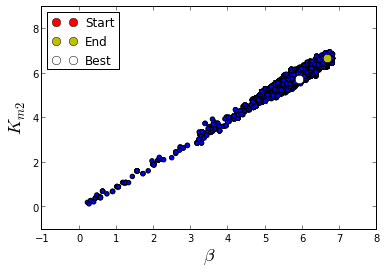

In [24]:
scatter(beta, K_m2)
plot(beta[0],K_m2[0],"ro", ms=8.0, label='Start')
plot(beta[-1],K_m2[-1],"yo", ms=8.0, label='End')
plot(beta[opt],K_m2[opt],"wo", ms=8.0, label='Best')
xlabel(r'$\beta$', size='18')
ylabel(r'$K_{m2}$', size='18')
legend(loc=2)
savefig('betaK2Walk.png')

# $S_0$ Walks Scatter Plots

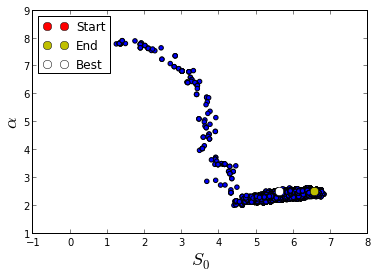

In [25]:
scatter(S_0, alpha)
plot(S_0[0],alpha[0],"ro", ms=8.0, label='Start')
plot(S_0[-1],alpha[-1],"yo", ms=8.0, label='End')
plot(S_0[opt],alpha[opt],"wo", ms=8.0, label='Best')
xlabel(r'$S_0$', size='18')
ylabel(r'$\alpha$', size='18')
legend(loc=2)
savefig('s0AlphaWalk.png')

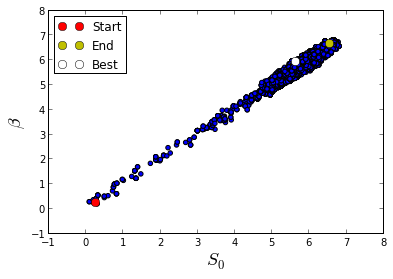

In [26]:
scatter(S_0, beta)
plot(S_0[0],beta[0],"ro", ms=8.0, label='Start')
plot(S_0[-1],beta[-1],"yo", ms=8.0, label='End')
plot(S_0[opt],beta[opt],"wo", ms=8.0, label='Best')
xlabel(r'$S_0$', size='18')
ylabel(r'$\beta$', size='18')
legend(loc=2)
savefig('s0BetaWalk.png')

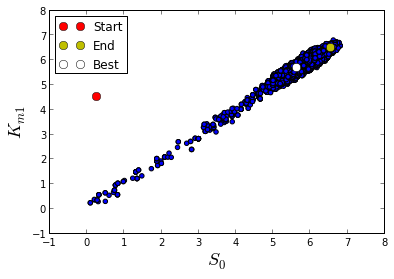

In [27]:
scatter(S_0, K_m1)
plot(S_0[0],K_m1[0],"ro", ms=8.0, label='Start')
plot(S_0[-1],K_m1[-1],"yo", ms=8.0, label='End')
plot(S_0[opt],K_m1[opt],"wo", ms=8.0, label='Best')
xlabel(r'$S_0$', size='18')
ylabel(r'$K_{m1}$', size='18')
legend(loc=2)
savefig('s0K1Walk.png')

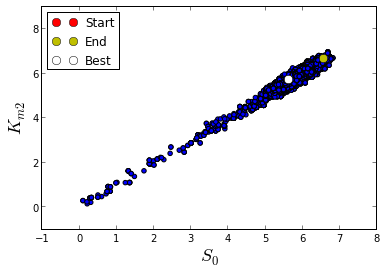

In [28]:
scatter(S_0, K_m2)
plot(S_0[0],K_m2[0],"ro", ms=8.0, label='Start')
plot(S_0[-1],K_m2[-1],"yo", ms=8.0, label='End')
plot(S_0[opt],K_m2[opt],"wo", ms=8.0, label='Best')
xlabel(r'$S_0$', size='18')
ylabel(r'$K_{m2}$', size='18')
legend(loc=2)
savefig('s0K2Walk.png')

# $K_{m1}$ Walks Scatter Plots

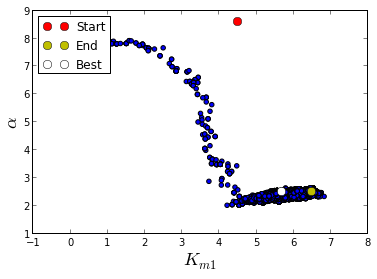

In [29]:
scatter(K_m1, alpha)
plot(K_m1[0],alpha[0],"ro", ms=8.0, label='Start')
plot(K_m1[-1],alpha[-1],"yo", ms=8.0, label='End')
plot(K_m1[opt],alpha[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m1}$', size='18')
ylabel(r'$\alpha$', size='18')
legend(loc=2)
savefig('k1AlphaWalk.png')

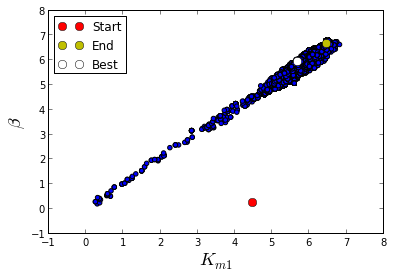

In [30]:
scatter(K_m1, beta)
plot(K_m1[0],beta[0],"ro", ms=8.0, label='Start')
plot(K_m1[-1],beta[-1],"yo", ms=8.0, label='End')
plot(K_m1[opt],beta[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m1}$', size='18')
ylabel(r'$\beta$', size='18')
legend(loc=2)
savefig('k1BetaWalk.png')

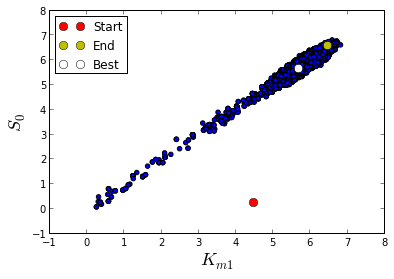

In [31]:
scatter(K_m1, S_0)
plot(K_m1[0],S_0[0],"ro", ms=8.0, label='Start')
plot(K_m1[-1],S_0[-1],"yo", ms=8.0, label='End')
plot(K_m1[opt],S_0[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m1}$', size='18')
ylabel(r'$S_0$', size='18')
legend(loc=2)
savefig('k1S0Walk.png')

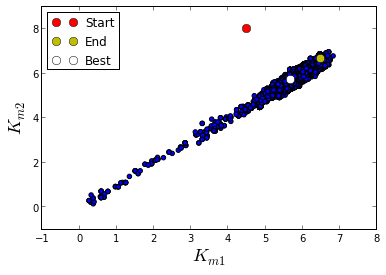

In [32]:
scatter(K_m1, K_m2)
plot(K_m1[0],K_m2[0],"ro", ms=8.0, label='Start')
plot(K_m1[-1],K_m2[-1],"yo", ms=8.0, label='End')
plot(K_m1[opt],K_m2[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m1}$', size='18')
ylabel(r'$K_{m2}$', size='18')
legend(loc=2)
savefig('k1K2Walk.png')

## $K_{m2}$ Walks Scatter Plots

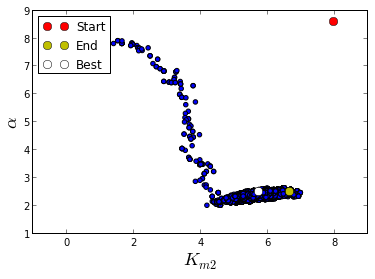

In [33]:
scatter(K_m2, alpha)
plot(K_m2[0],alpha[0],"ro", ms=8.0, label='Start')
plot(K_m2[-1],alpha[-1],"yo", ms=8.0, label='End')
plot(K_m2[opt],alpha[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m2}$', size='18')
ylabel(r'$\alpha$', size='18')
legend(loc=2)
savefig('k2AlphaWalk.png')

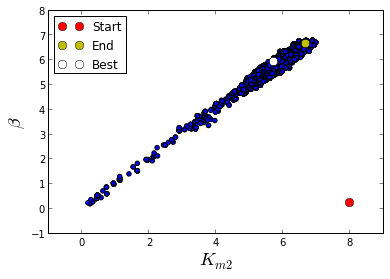

In [34]:
scatter(K_m2, beta)
plot(K_m2[0],beta[0],"ro", ms=8.0, label='Start')
plot(K_m2[-1],beta[-1],"yo", ms=8.0, label='End')
plot(K_m2[opt],beta[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m2}$', size='18')
ylabel(r'$\beta$', size='18')
legend(loc=2)
savefig('k2BetaWalk.png')

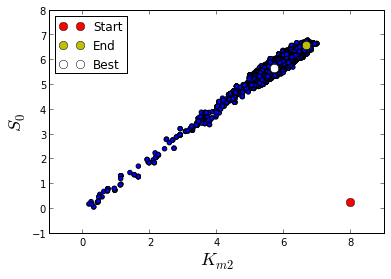

In [35]:
scatter(K_m2, S_0)
plot(K_m2[0],S_0[0],"ro", ms=8.0, label='Start')
plot(K_m2[-1],S_0[-1],"yo", ms=8.0, label='End')
plot(K_m2[opt],S_0[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m2}$', size='18')
ylabel(r'$S_0$', size='18')
legend(loc=2)
savefig('k2S0Walk.png')

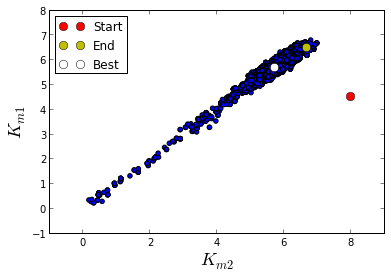

In [36]:
scatter(K_m2, K_m1)
plot(K_m2[0],K_m1[0],"ro", ms=8.0, label='Start')
plot(K_m2[-1],K_m1[-1],"yo", ms=8.0, label='End')
plot(K_m2[opt],K_m1[opt],"wo", ms=8.0, label='Best')
xlabel(r'$K_{m2}$', size='18')
ylabel(r'$K_{m1}$', size='18')
legend(loc=2)
savefig('k2K1Walk.png')

In [38]:
from scipy.interpolate import griddata

## Contour Plots

In [63]:
alphav = linspace(min(alpha), max(alpha), 300)
betav  = linspace(min(beta), max(beta), 300)
Av, Bv = meshgrid(alphav, betav)
zv = griddata((alpha, beta), chi, (Av,Bv), method='cubic')

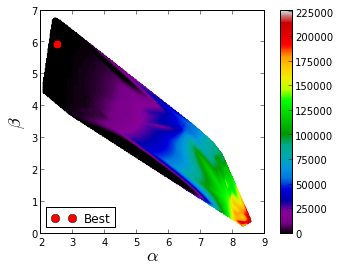

In [90]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(alpha), max(alpha), min(beta), max(beta)], cmap=cm.spectral)
colorbar()
xlabel(r'$\alpha$', size='18')
ylabel(r'$\beta$', size='18')
plot(alpha[opt], beta[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('alphaBetaContour.png')

In [80]:
alphav = linspace(min(alpha), max(alpha), 300)
sv  = linspace(min(S_0), max(S_0), 300)
Av, Sv = meshgrid(alphav, sv)
zv = griddata((alpha, S_0), chi, (Av,Sv), method='cubic')

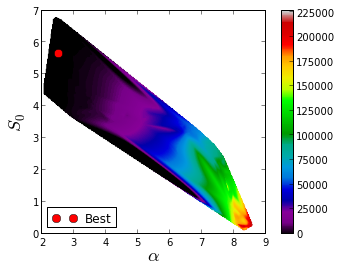

In [89]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(alpha), max(alpha), min(S_0), max(S_0)], cmap=cm.spectral)
colorbar()
xlabel(r'$\alpha$', size='18')
ylabel(r'$S_0$', size='18')
plot(alpha[opt], S_0[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('alphaS0Contour.png')

In [95]:
alphav = linspace(min(alpha), max(alpha), 300)
k1v  = linspace(min(K_m1), max(K_m1), 300)
Av, K1v = meshgrid(alphav, k1v)
zv = griddata((alpha, K_m1), chi, (Av,K1v), method='cubic')

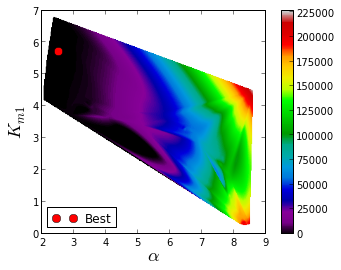

In [96]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(alpha), max(alpha), min(K_m1), max(K_m1)], cmap=cm.spectral)
colorbar()
xlabel(r'$\alpha$', size='18')
ylabel(r'$K_{m1}$', size='18')
plot(alpha[opt], K_m1[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('alphaK1Contour.png')

In [97]:
alphav = linspace(min(alpha), max(alpha), 300)
k2v  = linspace(min(K_m2), max(K_m2), 300)
Av, K2v = meshgrid(alphav, k2v)
zv = griddata((alpha, K_m2), chi, (Av,K2v), method='cubic')

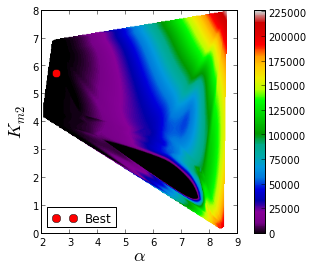

In [98]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(alpha), max(alpha), min(K_m2), max(K_m2)], cmap=cm.spectral)
colorbar()
xlabel(r'$\alpha$', size='18')
ylabel(r'$K_{m2}$', size='18')
plot(alpha[opt], K_m2[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('alphaK2Contour.png')

In [100]:
betav = linspace(min(beta), max(beta), 300)
sv  = linspace(min(S_0), max(S_0), 300)
Bv, Sv = meshgrid(betav, sv)
zv = griddata((beta, S_0), chi, (Bv,Sv), method='cubic')

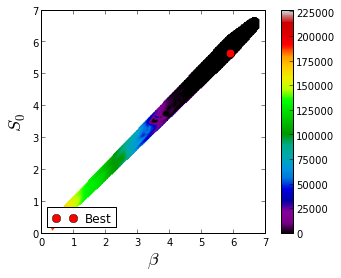

In [102]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(beta), max(beta), min(S_0), max(S_0)], cmap=cm.spectral)
colorbar()
xlabel(r'$\beta$', size='18')
ylabel(r'$S_0$', size='18')
plot(beta[opt], S_0[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('betaS0Contour.png')

In [103]:
betav = linspace(min(beta), max(beta), 300)
k1v  = linspace(min(K_m1), max(K_m1), 300)
Bv, K1v = meshgrid(betav, k1v)
zv = griddata((beta, K_m1), chi, (Bv,K1v), method='cubic')

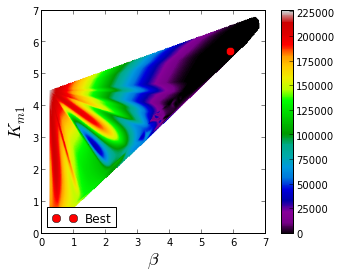

In [104]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(beta), max(beta), min(K_m1), max(K_m1)], cmap=cm.spectral)
colorbar()
xlabel(r'$\beta$', size='18')
ylabel(r'$K_{m1}$', size='18')
plot(beta[opt], K_m1[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('betaK1Contour.png')

In [105]:
betav = linspace(min(beta), max(beta), 300)
k2v  = linspace(min(K_m2), max(K_m2), 300)
Bv, K2v = meshgrid(betav, k2v)
zv = griddata((beta, K_m2), chi, (Bv,K2v), method='cubic')

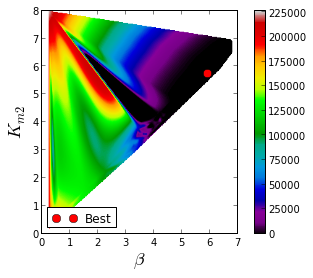

In [106]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(beta), max(beta), min(K_m2), max(K_m2)], cmap=cm.spectral)
colorbar()
xlabel(r'$\beta$', size='18')
ylabel(r'$K_{m2}$', size='18')
plot(beta[opt], K_m2[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('betaK2Contour.png')

In [107]:
sv = linspace(min(S_0), max(S_0), 300)
k1v  = linspace(min(K_m1), max(K_m1), 300)
Sv, K1v = meshgrid(sv, k1v)
zv = griddata((S_0, K_m1), chi, (Sv,K1v), method='cubic')

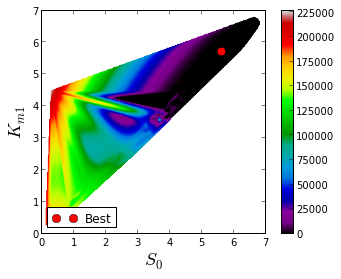

In [108]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(S_0), max(S_0), min(K_m1), max(K_m1)], cmap=cm.spectral)
colorbar()
xlabel(r'$S_0$', size='18')
ylabel(r'$K_{m1}$', size='18')
plot(S_0[opt], K_m1[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('s0K1Contour.png')

In [109]:
sv = linspace(min(S_0), max(S_0), 300)
k2v  = linspace(min(K_m2), max(K_m2), 300)
Sv, K2v = meshgrid(sv, k2v)
zv = griddata((S_0, K_m2), chi, (Sv,K2v), method='cubic')

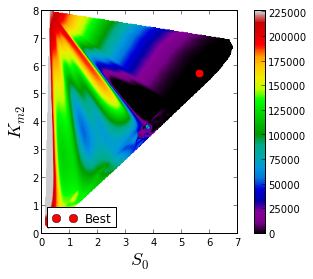

In [110]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(S_0), max(S_0), min(K_m2), max(K_m2)], cmap=cm.spectral)
colorbar()
xlabel(r'$S_0$', size='18')
ylabel(r'$K_{m2}$', size='18')
plot(S_0[opt], K_m2[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('s0K2Contour.png')

In [111]:
k1v = linspace(min(K_m1), max(K_m1), 300)
k2v  = linspace(min(K_m2), max(K_m2), 300)
K1v, K2v = meshgrid(k1v, k2v)
zv = griddata((K_m1, K_m2), chi, (K1v,K2v), method='cubic')

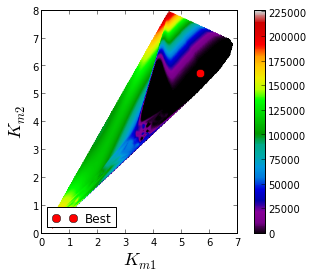

In [112]:
imshow(zv, vmin=min(chi), vmax=max(chi), origin='lower', extent=[min(K_m1), max(K_m1), min(K_m2), max(K_m2)], cmap=cm.spectral)
colorbar()
xlabel(r'$K_{m1}$', size='18')
ylabel(r'$K_{m2}$', size='18')
plot(K_m1[opt], K_m2[opt], 'ro',ms=8.0, label='Best')
legend(loc=3)
savefig('k1K2Contour.png')

## Parameter Uncertainty (Based on the contour plots)

#### $\sigma \alpha \approx$ 1.0

#### $\sigma \beta \approx$ 2.5

#### $\sigma S_0 \approx$ 2.0

#### $\sigma K_{m1} \approx$ 1.5

#### $\sigma K_{m2} \approx$ 1.8

## Comentarios

Introducción:

*Después de un análisis el método de MCMC, se puede encontrar la utilidad del método mencionado gracias a la facilidad que este brinda para encontrar los parámetros.

Consideraciones a la hora de usar el método:

*Hasta la última semana se debe considerar el uso de una región continua para su uso.

Observaciones del chi cuadrado:

*El chi cuadrado que se obtiene es un valor muy pequeño para los parámetros más óptimos, variando entre 5 y 5.5. Esto demuestra una gran fiabilidad del método a usar.

Incertidumbres:

*Las incertidumbres obtenidas muestran una gran fiabilidad de los datos dado que se obtienen unas incertidumbres apropiadas para la práctica hecha.
Se puede ver que esto tiene sentido, pues las incertidumbres oscilan en los mismos valores todo el tiempo.